# Homework week N

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [1]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


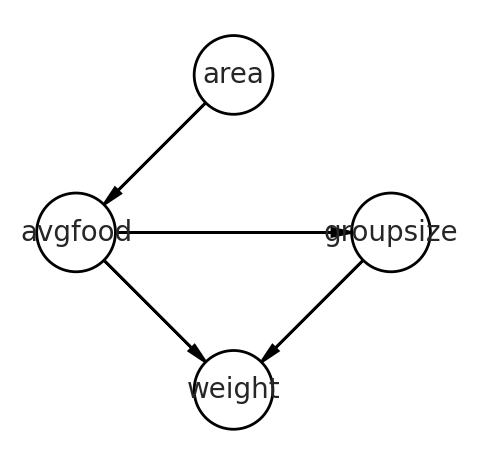

<IPython.core.display.Javascript object>

In [6]:
dag = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "area": (1, 1),
    "avgfood": (0, 0),
    "groupsize": (2, 0),
    "weight": (1, -1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

# Q1

xxxxxx

## Answer

yyyyyyy


Markdown/Latex for system of equations
$$ F \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta_A A $$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_{A} \sim \text{Normal}(0, 3) $$
$$ \sigma \sim \text{Exp}(1) $$

In [7]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df = pd.read_csv(DATA_DIR + "foxes.csv", sep=";", header=0)
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


<IPython.core.display.Javascript object>

In [8]:
# standardize variables
df['area_std'] = standardize(df['area'])
df.head()

,group,avgfood,groupsize,area,weight,area_std
0,1,0.37,2,1.09,5.02,-2.249313
1,1,0.37,2,1.09,2.84,-2.249313
2,2,0.53,2,2.05,5.33,-1.210738
3,2,0.53,2,2.05,6.07,-1.210738
4,3,0.49,2,2.12,5.85,-1.135008


<IPython.core.display.Javascript object>

In [8]:
# write model
with pm.Model() as mq1:

    # Priors are variables a, b, sigma (all stochastic)
    a = pm.Normal("a", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a + bA * df['area_std']

    # likelihood
    f = pm.Normal("f", mu=mu, sd=sigma, observed=df['avgfood_std'])

    # prior predictive simulation
    prior_checks = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    idata_mq1 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictive simulation
    posterior_checks = pm.sample_prior_predictive(samples=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Prior predictive checks')

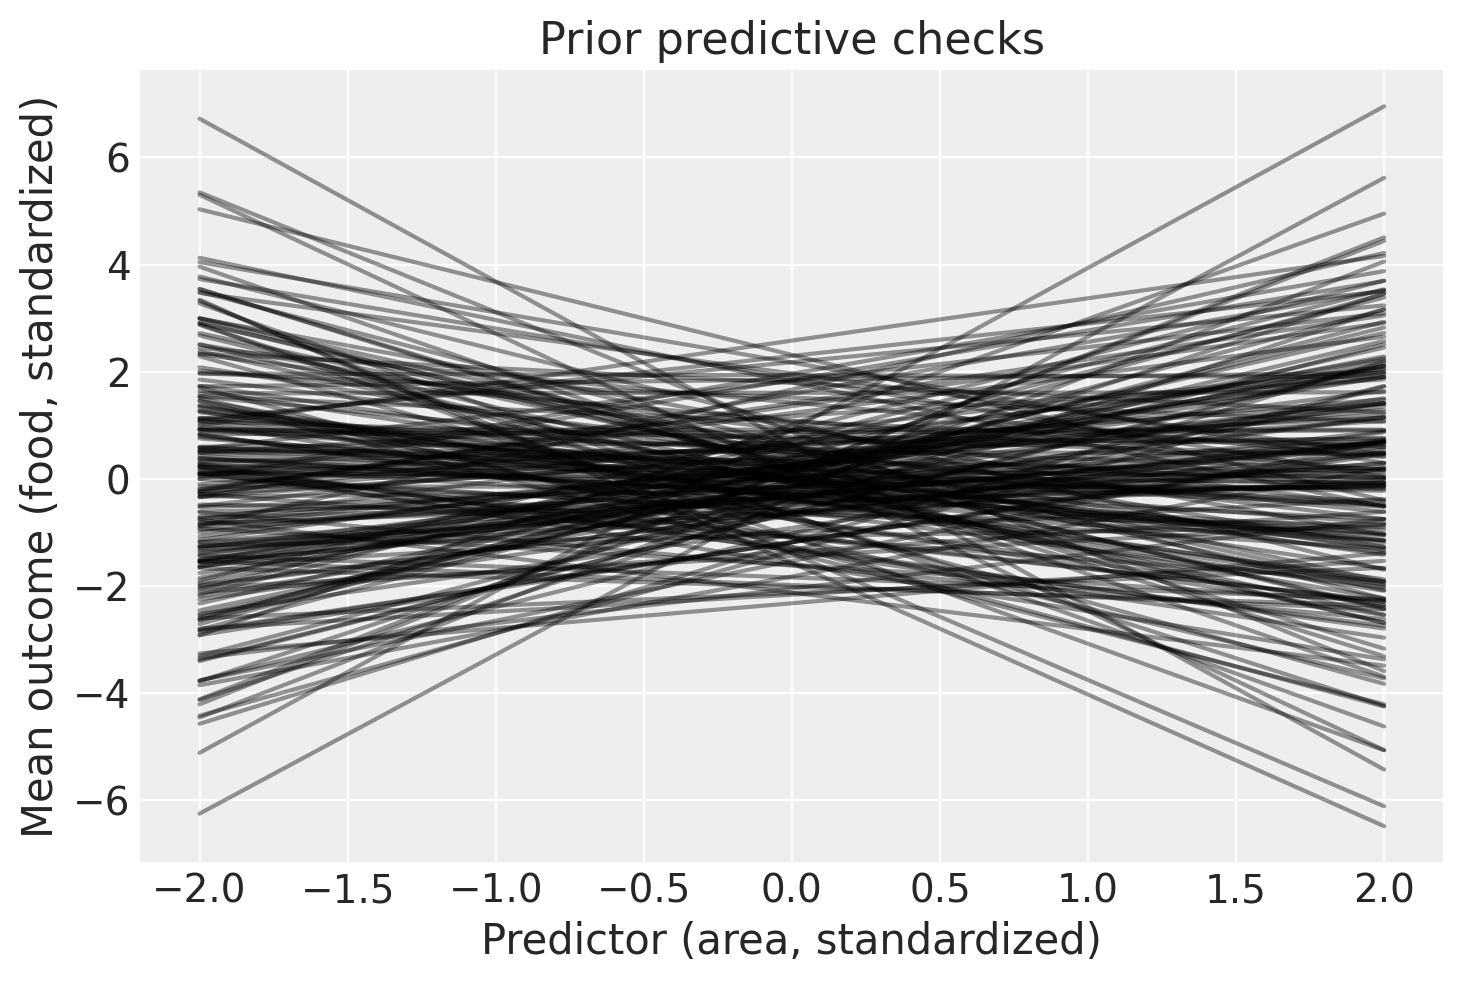

<IPython.core.display.Javascript object>

In [9]:
# prior checks
f, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, bA in zip(prior_checks["a"], prior_checks["bA"]):
    y = a + bA * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (food, standardized)")
ax.set_title("Prior predictive checks")

In [10]:
az.summary(idata_mq1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.043,-0.071,0.066,0.001,0.001,6182.0,2059.0,6189.0,3041.0,1.0
bA,0.883,0.044,0.812,0.954,0.001,0.000,5462.0,5389.0,5483.0,3248.0,1.0
sigma,0.477,0.032,0.428,0.529,0.000,0.000,5613.0,5590.0,5564.0,2718.0,1.0


<IPython.core.display.Javascript object>

**This says that increasing the area by one standard deviation will produce about 0.882 standardized units of average food.**

In [11]:
x = np.linspace(df_foxes["avgfood_std"].min(), df_foxes["avgfood_std"].max(), 50)
x

array([-1.93317993, -1.84636271, -1.75954549, -1.67272828, -1.58591106,
       -1.49909384, -1.41227662, -1.32545941, -1.23864219, -1.15182497,
       -1.06500776, -0.97819054, -0.89137332, -0.80455611, -0.71773889,
       -0.63092167, -0.54410445, -0.45728724, -0.37047002, -0.2836528 ,
       -0.19683559, -0.11001837, -0.02320115,  0.06361606,  0.15043328,
        0.2372505 ,  0.32406772,  0.41088493,  0.49770215,  0.58451937,
        0.67133658,  0.7581538 ,  0.84497102,  0.93178823,  1.01860545,
        1.10542267,  1.19223989,  1.2790571 ,  1.36587432,  1.45269154,
        1.53950875,  1.62632597,  1.71314319,  1.7999604 ,  1.88677762,
        1.97359484,  2.06041205,  2.14722927,  2.23404649,  2.32086371])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Posterior predictive checks')

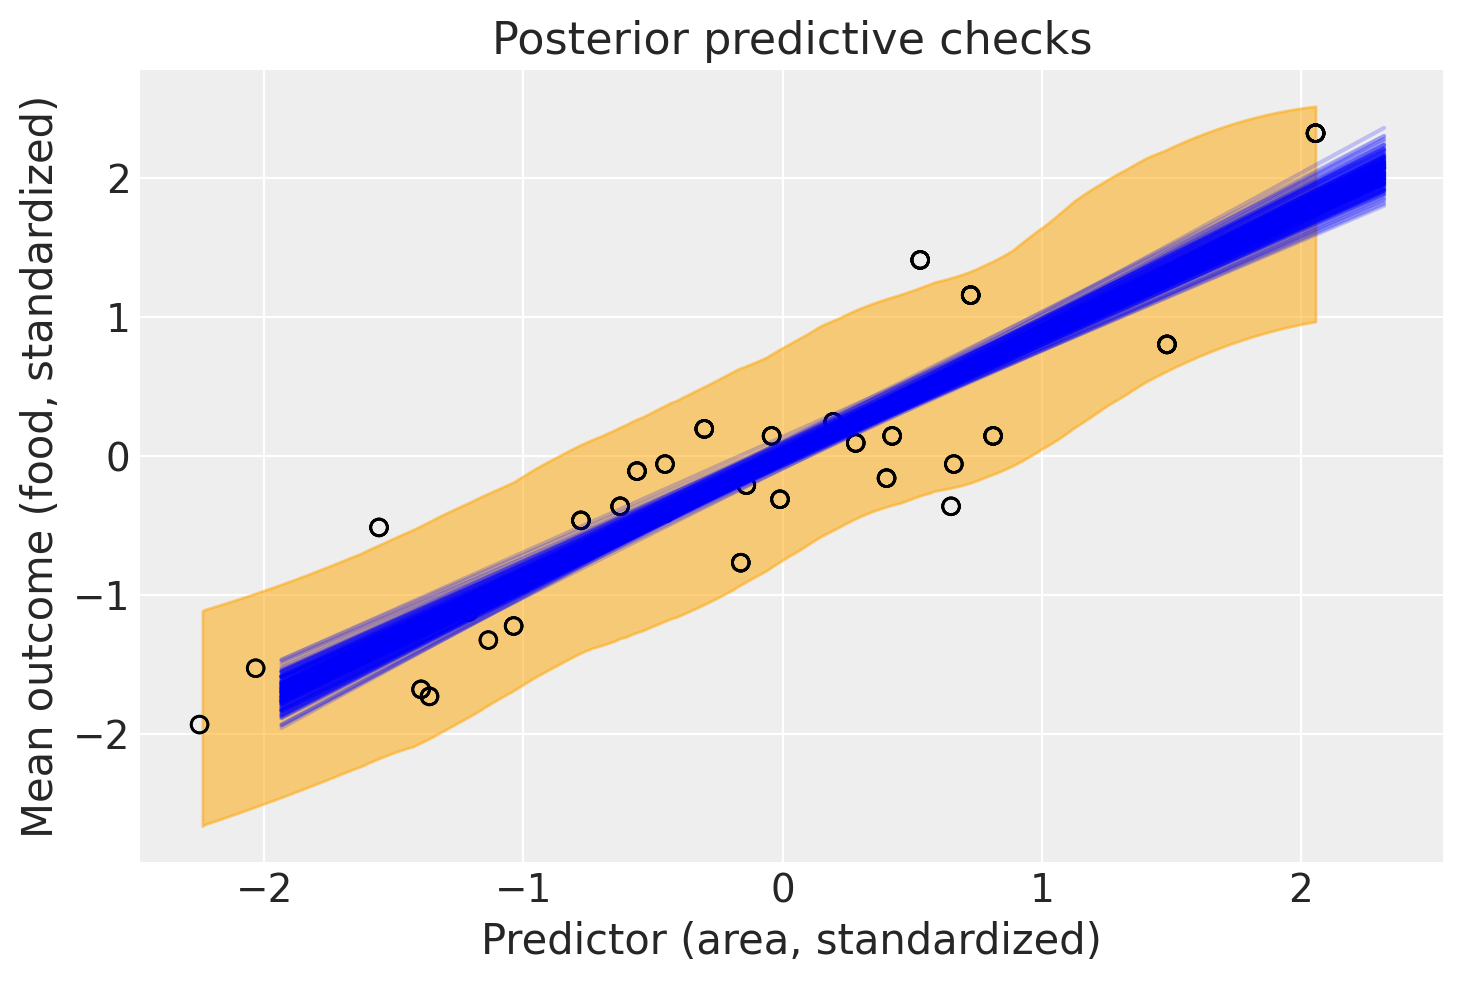

<IPython.core.display.Javascript object>

In [12]:
with mq1:
    posterior_checks = pm.sample_posterior_predictive(trace=idata_mq1, var_names=['a', 'bA', 'f'], samples=200)

# posterior checks
f, ax = plt.subplots()

# Plotting mean lines
x = np.linspace(df_foxes["avgfood_std"].min(), df_foxes["avgfood_std"].max(), 50)
for a, bA in zip(posterior_checks["a"], posterior_checks["bA"]):
    y = a + bA * x
    ax.plot(x, y, c="blue", alpha=0.2)

# Uncertainty around all predictions
az.plot_hdi(df_foxes["area_std"], posterior_checks["f"], color='orange', ax=ax)

# All raw data
ax.scatter(df_foxes["area_std"], df_foxes["avgfood_std"], facecolors='none', edgecolors='k')

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (food, standardized)")
ax.set_title("Posterior predictive checks")

In [13]:
# Make predictions using a function
def predict_sim(x, idata):
    
    # mean (easy to get)
    hi_mean = az.summary(idata).loc['a', 'mean'] + az.summary(idata).loc['bA', 'mean'] * x
    
    # make it accessible
    idata_df = idata.to_dataframe()

    # uncertainty requires thinking generatively
    mu_post_hi =idata_df[('posterior', 'a')] + idata_df[('posterior', 'bA')].mean() * x
    sigma_post_hi = idata_df[('posterior', 'sigma')]
    hpdi_89 = az.hdi(stats.norm.rvs(mu_post_hi, sigma_post_hi))

    return hi_mean, hpdi_89

<IPython.core.display.Javascript object>

Why are the posterior predicitions "squiggly"? It's just sampling variation. This is the line that samples.

`hpdi_89 = az.hdi(stats.norm.rvs(mu_post_hi, sigma_post_hi))`

In [14]:
az.summary(idata_mq1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.043,-0.071,0.066,0.001,0.001,6182.0,2059.0,6189.0,3041.0,1.0
bA,0.883,0.044,0.812,0.954,0.001,0.000,5462.0,5389.0,5483.0,3248.0,1.0
sigma,0.477,0.032,0.428,0.529,0.000,0.000,5613.0,5590.0,5564.0,2718.0,1.0


<IPython.core.display.Javascript object>

# Q2
xxxxx

## Answer


yyyyyyy


In [16]:
with pm.Model() as mq2a:

    # priors
    a = pm.Normal("a", 0, 1)
    bF = pm.Normal("bF", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = a + bF*df['avgfood_std']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed=df_foxes['weight_std'])

    # posterior
    idata_mq2a = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictions
    post_pred_mq2a = pm.sample_posterior_predictive(trace=idata_mq2a, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'direct effect of food on weight')

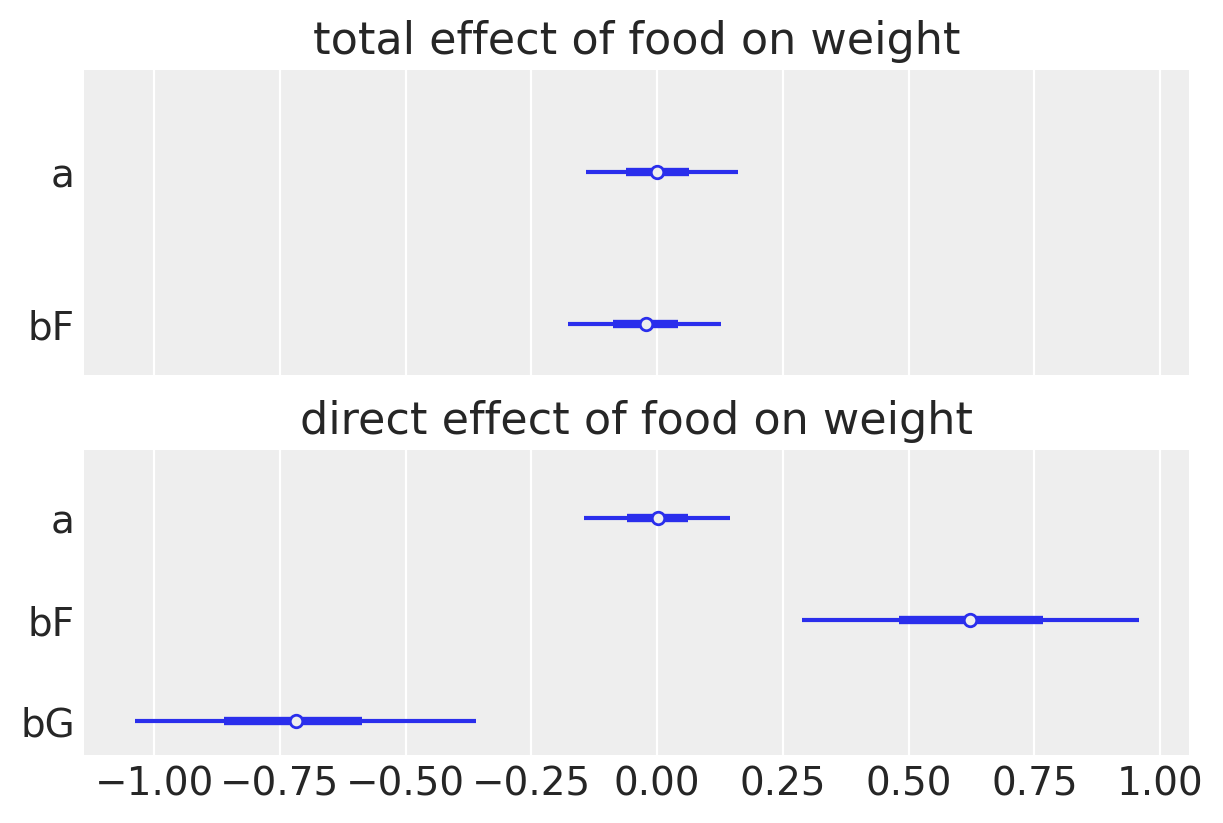

<IPython.core.display.Javascript object>

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
az.plot_forest(idata_mq2a, var_names=['a', 'bF'], combined=True, ax=ax1)
ax1.set_title("total effect of food on weight")

az.plot_forest(idata_mq2b, var_names=['a', 'bF', 'bG'], combined=True, ax=ax2)
ax2.set_title("direct effect of food on weight")

It is clear from the direct effect model that food has a positive impact on weight. However, when looking at the total effect, it appears that the effect of food gets blunted by the size of the group. Being part of a group with more members means that the food gets divided up for an individual fox. This is an instance of masked association (?).

When considering area though (Q1), a bigger territory can increase the overall quantity of food for an individual fox, because it is not affected by group size (A has no arrows pointing into it from G).


In [19]:
df_foxes.head()

,group,avgfood,groupsize,area,weight,area_std,avgfood_std,groupsize_std,weight_std
0,1,0.37,2,1.09,5.02,-2.249313,-1.933180,-1.530701,0.415931
1,1,0.37,2,1.09,2.84,-2.249313,-1.933180,-1.530701,-1.433238
2,2,0.53,2,2.05,5.33,-1.210738,-1.122886,-1.530701,0.678887
3,2,0.53,2,2.05,6.07,-1.210738,-1.122886,-1.530701,1.306586
4,3,0.49,2,2.12,5.85,-1.135008,-1.325459,-1.530701,1.119973


<IPython.core.display.Javascript object>

In [20]:
# Look for masked relationship? 
# sns.pairplot(df_foxes[['avgfood_std', 'groupsize_std', 'weight_std']])
# food and groupsize look correlated, but neither have obvious correlation with weight

<IPython.core.display.Javascript object>

# Q3

xxxxx

yyyyyy

## Answer

Tables 

| Coefficient on Y  |  Interpretation |
| ---- | ------- |
| X | direct and total effect |
| S | confounded effect because U is a fork that acts on S and Y |
| A | confounded effect because of path opened by conditioning on S (originally closed due to collider created by U) |


It's helpful to look at the scenario *without* U (lecture example). 


# Q4 (optional)

xxxxx

## Answer

yyyyyyy

### Replicating lecture 6 example

Using lecture 6, slide 83 example. R code shown below

```
f <- function(n=100,bZX=1,bXY=1) {
Z <- rnorm(n)
X <- rnorm(n, bZX*Z )
Y <- rnorm(n, bXY*X )
bX <- coef( lm(Y ~ X) )['X']
bXZ <- coef( lm(Y ~ X + Z) )['X']
return( c(bX,bXZ) )
}
sim <- mcreplicate( 1e4 , f(n=50) , mc.cores=8 )
dens( sim[1,] , lwd=3 , xlab="posterior mean" )
dens( sim[2,] , lwd=3 , col=2 , add=TRUE )

```

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>